In [187]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [188]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection, metrics
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [227]:
train_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\train.csv'
test_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\test.csv'
user_logs='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\historical_user_logs.csv'
test_result='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\train_result.csv'
train=pd.read_csv(train_file)
test=pd.read_csv(test_file)
user_log=pd.read_csv(user_logs)
test_results=pd.read_csv(test_result)

In [190]:
target = 'is_click'
IDcol = 'session_id'

In [191]:
#is_click_count= len(train[train.is_click==1])
#non_click_indices = train[train.is_click==0].index
#random_indices = np.random.choice(non_click_indices,is_click_count*2, replace=False)
#click_indices = train[train.is_click==1].index
#under_sample_indices = np.concatenate([click_indices,random_indices])
#under_sample = train.loc[under_sample_indices]
#train=under_sample

In [228]:
user_log_view=user_log[user_log.action=='view']
user_log_interest=user_log[user_log.action=='interest']

In [229]:
user_log_interest=user_log_interest.groupby(['user_id','product']).action.count().reset_index()

In [230]:
user_log_interest.rename(columns={'action': 'interest'}, inplace=True)
user_log_interest.head()

,user_id,product,interest
0,19,D,1
1,19,F,2
2,19,G,2
3,26,H,1
4,30,H,1


In [231]:
user_log_view=user_log_view.groupby(['user_id','product']).action.count().reset_index()

In [232]:
user_log_view.rename(columns={'action': 'view'}, inplace=True)
user_log_view.head()


,user_id,product,view
0,4,A,3
1,4,B,1
2,4,H,1
3,4,I,2
4,19,A,14


In [233]:
train['source']='train'
test['source']='test'
train=train.append(test)
train.info()


C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 592149 entries, 0 to 128857
Data columns (total 16 columns):
DateTime                  592149 non-null object
age_level                 568222 non-null float64
campaign_id               592149 non-null int64
city_development_index    432411 non-null float64
gender                    568222 non-null object
is_click                  463291 non-null float64
product                   592149 non-null object
product_category_1        592149 non-null int64
product_category_2        150124 non-null float64
session_id                592149 non-null int64
source                    592149 non-null object
user_depth                568222 non-null float64
user_group_id             568222 non-null float64
user_id                   592149 non-null int64
var_1                     592149 non-null int64
webpage_id                592149 non-null int64
dtypes: float64(6), int64(6), object(4)
memory usage: 76.8+ MB


In [234]:
train=pd.merge(train,user_log_interest,how='left', on=['user_id','product'])
train=pd.merge(train,user_log_view,how='left', on=['user_id','product'])

In [235]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592149 entries, 0 to 592148
Data columns (total 18 columns):
DateTime                  592149 non-null object
age_level                 568222 non-null float64
campaign_id               592149 non-null int64
city_development_index    432411 non-null float64
gender                    568222 non-null object
is_click                  463291 non-null float64
product                   592149 non-null object
product_category_1        592149 non-null int64
product_category_2        150124 non-null float64
session_id                592149 non-null int64
source                    592149 non-null object
user_depth                568222 non-null float64
user_group_id             568222 non-null float64
user_id                   592149 non-null int64
var_1                     592149 non-null int64
webpage_id                592149 non-null int64
interest                  103101 non-null float64
view                      478310 non-null float64
dtype

In [200]:
t_click1=train[train.is_click==1]
train=train.append(t_click1)
train=train.append(t_click1)

In [201]:
train=train.append(t_click1)

In [202]:
train.isnull().sum()

DateTime                       0
age_level                  27749
campaign_id                    0
city_development_index    185184
gender                     27749
is_click                  128858
product                        0
product_category_1             0
product_category_2        517460
session_id                     0
source                         0
user_depth                 27749
user_group_id              27749
user_id                        0
var_1                          0
webpage_id                     0
interest                  566643
view                      131119
dtype: int64

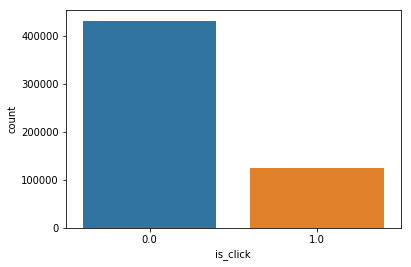

In [203]:
sb.countplot(train.is_click)

In [204]:
train.gender=train.gender.fillna('Unknown')

In [205]:
train.city_development_index= train.city_development_index.fillna(method='pad')

In [206]:
train.age_level= train.age_level.fillna(method='pad')

In [207]:
train.user_depth= train.user_depth.fillna(method='pad')

In [208]:
train.user_group_id= train.user_group_id.fillna(method='pad')

In [209]:
train.view=train.view.fillna(0)
train.interest=train.interest.fillna(0)

In [210]:
train=pd.get_dummies(train,columns=['gender','product'])

In [211]:
train.head()

,DateTime,age_level,campaign_id,city_development_index,is_click,product_category_1,product_category_2,session_id,source,user_depth,...,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,2017-07-02 00:00,4.0,359520,3.0,0.0,4,NaN,140690,train,3.0,...,0,0,1,0,0,0,0,0,0,0
1,2017-07-02 00:00,2.0,105960,3.0,0.0,5,NaN,333291,train,2.0,...,0,0,1,0,0,0,0,0,0,0
2,2017-07-02 00:00,2.0,359520,3.0,0.0,4,NaN,129781,train,2.0,...,0,0,1,0,0,0,0,0,0,0
3,2017-07-02 00:00,3.0,359520,2.0,0.0,3,NaN,464848,train,3.0,...,0,0,0,0,0,0,0,0,1,0
4,2017-07-02 00:01,2.0,405490,2.0,0.0,3,NaN,90569,train,3.0,...,0,0,1,0,0,0,0,0,0,0


In [212]:
train= train.drop(['DateTime','user_id','product_category_2','session_id'],axis=1)

In [250]:
def f1(view):
    if (view < 3):
        return 1
    else:
        return 0

In [252]:
train.view=train['view'].apply(f1)

In [254]:
def f2(interest):
    if (interest > 0):
        return 0
    else:
        return 1

In [255]:
train.interest=train['interest'].apply(f1)

In [256]:
train[['user_id','product','view','interest']]

,user_id,product,view,interest
0,858557,C,0,1
1,243253,C,0,1
2,243253,C,0,1
3,1097446,I,0,0
4,663656,C,0,1
5,509591,I,0,1
6,1091463,F,0,0
7,469098,C,0,1
8,611906,H,0,0
9,418107,B,0,0


In [214]:
#train.drop('source',axis=1,inplace=True)

In [215]:
#test.drop('source',axis=1,inplace=True)

In [216]:
test=train[train.source=='test']
test.drop(['source','is_click'],axis=1,inplace=True)
train=train[train.source=='train']
train.drop(['source'],axis=1,inplace=True)

C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [217]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['is_click'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['is_click'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['is_click'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.7771
AUC Score (Train): 0.643744


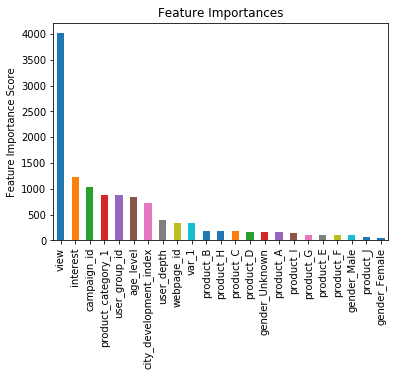

In [218]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=500,
        max_depth=5,
       # min_child_weight=1,
      #  gamma=0,
       # subsample=0.8,
        colsample_bytree=0.3,
        objective= 'binary:logistic',
    # nthread=4,
       # scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, predictors)

In [219]:
pred=xgb1.predict(test[predictors])

In [220]:
prediction=pd.Series(pred.tolist()).astype(int)

In [221]:
prediction.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/AmericanExpress/predictionxgb.csv')

In [222]:
test.shape

(128858, 23)

Text(0,0.5,'Feature Importance Score')

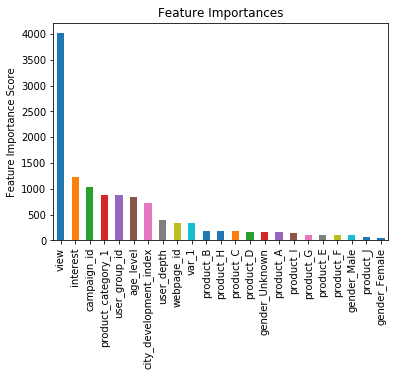

In [223]:
feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [224]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
from sklearn.grid_search import GridSearchCV
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.5,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
gsearch2.fit(train[predictors],train[target])

ModuleNotFoundError: No module named 'sklearn.grid_search'